# <a id='toc1_'></a>Machine Learning: TFIDF + MultinomialNaiveBayes classification  [&#128522;](#toc0_)

**Nội dung, Table of contents**<a id='toc0_'></a>    
- [Machine Learning: TFIDF + MultinomialNaiveBayes classification ](#toc1_)    
    - [Thiết lập, Setup ](#toc1_1_1_)    
    - [Vectơ hóa văn bản với TfidfVectorizer, Text Vectorization with TfidfVectorizer ](#toc1_1_2_)    
    - [Phân loại với Multinomial Naive Bayes, điều chỉnh siêu tham số và đánh giá mô hình <br>Multinomial Naive Bayes Classifier, Hyperparameter Tuning and Model Evaluation ](#toc1_1_3_)    
    - [Dự đoán các lớp trên tập dữ liệu mới, Predicting Classes for New Data ](#toc1_1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>Thiết lập, Setup  [&#128522;](#toc0_)

In [1]:
# ### python environment (venv, virtualenv)
# %pip install numpy==1.25.2
# %pip install pandas==2.1.0
# %pip install scikit-learn==1.3.0
# ### conda environment (miniconda, anaconda)
# %conda install numpy==1.25.2
# %conda install pandas==2.1.0
# %conda install scikit-learn==1.3.0

### <a id='toc1_1_2_'></a>Vectơ hóa văn bản với TfidfVectorizer, Text Vectorization with TfidfVectorizer  [&#128522;](#toc0_)

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

train_df = pd.read_csv("data/train.csv", encoding="utf-8")
test_df = pd.read_csv("data/test.csv", encoding="utf-8")

train_x, valid_x = train_df["comment"], test_df["comment"]
train_y, valid_y = train_df["label"], test_df["label"]

vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.01, max_features=5000)
X_train = vectorizer.fit_transform(train_x)
X_valid = vectorizer.transform(valid_x)

In [3]:
X_train.data

array([0.22236232, 0.20336718, 0.29694172, ..., 0.39750256, 0.19937742,
       0.40356199])

### <a id='toc1_1_3_'></a>Phân loại với Multinomial Naive Bayes, điều chỉnh siêu tham số và đánh giá mô hình <br>Multinomial Naive Bayes Classifier, Hyperparameter Tuning and Model Evaluation  [&#128522;](#toc0_)


    Best alpha     : 0.1
    Avg. Precision : 0.6769400110071546
    Avg. Recall    : 0.6267244777296019
    Avg. F1        : 0.619235836627141

    
Per class evaluation
    Classes        : ['neg' 'pos']
    Precision      : [0.69565217 0.65822785]
    Recall         : [0.37209302 0.88135593]
    F1             : [0.48484848 0.75362319]


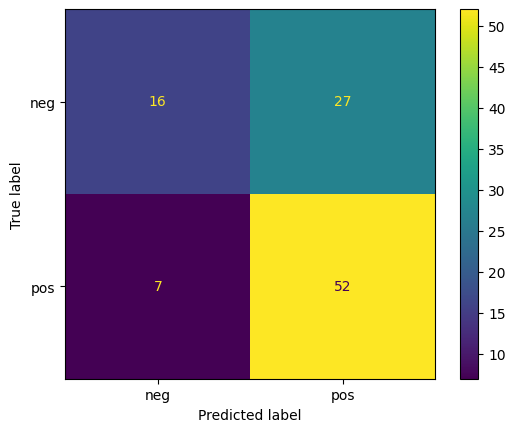

In [4]:
import numpy as np
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    precision_recall_fscore_support,
)
from sklearn.naive_bayes import MultinomialNB

def multinomialBN_model(X_train, train_y, X_valid, valid_y, alpha=1.0):
    model = MultinomialNB(alpha=alpha).fit(X_train, train_y)
    y_pred = model.predict(X_valid)
    (prec, recall, f1, class_size) = precision_recall_fscore_support(
        valid_y, y_pred, average=None, labels=model.classes_
    )
    scores = {
        "class_order": model.classes_,
        "precision": prec,
        "recall": recall,
        "f1": f1,
        "avg prec": np.mean(prec),
        "avg recall": np.mean(recall),
        "avg f1": np.mean(f1),
    }
    return model, scores, y_pred


models = {}
for alpha in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
    models[alpha] = multinomialBN_model(X_train, train_y, X_valid, valid_y, alpha=alpha)
f1_max = max([models[alpha][1]["avg f1"] for alpha in models])
best_alpha, best_model, best_score, y_pred = [
    (alpha, models[alpha][0], models[alpha][1], models[alpha][2])
    for alpha in models
    if models[alpha][1]["avg f1"] == f1_max
][0]
print(
    f"""
    Best alpha     : {best_alpha}
    Avg. Precision : {best_score["avg prec"]}
    Avg. Recall    : {best_score["avg recall"]}
    Avg. F1        : {best_score["avg f1"]}"""
)
print(
    f"""
    \nPer class evaluation
    Classes        : {best_score["class_order"]}
    Precision      : {best_score["precision"]}
    Recall         : {best_score["recall"]}
    F1             : {best_score["f1"]}"""
)

cm = confusion_matrix(valid_y, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()

In [5]:
from sklearn import metrics

metrics.accuracy_score(y_pred, valid_y)

0.6666666666666666

### <a id='toc1_1_4_'></a>Dự đoán các lớp trên tập dữ liệu mới, Predicting Classes for New Data  [&#128522;](#toc0_)

In [6]:
def clean(doc):
    import re
    text = doc
    # URL removal and to lower case
    text = re.sub(r"https?://\S+|www\.\S+", "", text).lower()
    # emotion removal
    emotion_list = [":v", "=d", ":d", "<3", ":3"]
    for emotion in emotion_list:
        text = text.replace(emotion, "")
    # special characters removal
    pattern = r"[^0-9,.\saAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ]"
    text = re.sub(pattern, " ", text)
    # convert to standard words
    # 8 củ -> 8 triệu, 8tr2 -> 8.2 triệu, 8tr -> 8 triệu
    text = re.sub(r"(\d+)\s+củ", r"\1 triệu", text)
    text = re.sub(r"(\d+)tr(\d+)", r"\1.\2 triệu", text)
    text = re.sub(r"(\d+)tr", r"\1 triệu", text)
    # remove duplicate spaces
    text = re.sub(r"\s+", " ", text)
    return text.strip()


In [7]:
new_samples = [
    'Con 6 nhanh nóng máy lắm, nhất là trời nóng thế này. Bác cố lên con 7 ý.',
    'Tầm 6h được đó bác, 7- 7Pro giờ nó khá mát, pin cũng ổn + rom gốc rất mượt.',
    'Em thấy ai cũng chê mà em dùng cũng mát, công sở nhiều khi sáng hôm trước đến trưa hôm sau mới sạc. Em không lướt fb với tiktok :D, game thì nhẹ nhàng 20 30 phút.',
    'pixel 7 - 7 pro giờ ROM sau 1 năm tối ưu khá tốt rồi bác, gần như không có mấy cái lỗi nóng linh tinh hay loạn cảm ứng như hồi mới ra nữa. Google camera sau 1 năm cũng được update nhiều bản khá tốt rồi.\
    mình dùng 7 pro lock adb, dùng 3 tháng rồi thấy vậy.',
    'Same, lỗi quá nhiệt là lý do em bán con Pixel 6 Pro đi. Mặc dù em ko hề chơi game nhé',
    'con đó 8a nhìn cầm vừa vặn mà bạn. màn hình phẳng nữa chắc dễ cầm nắm',
    'Ngon - bổ - khá rẻ bác nhé, độ mượt thì max level ',
    'con này nó bo góc nhiều nhưng cái cam lại kẻ 2 vạch thẳng nên thấy lạc quẻ, làm cái cam vẫn ngang nhưng bo bên trong lại như pixel fold nhìn có thể đỡ thấy cái cam nó lạc lõng hơn',
    'con 5a cũng tử nhiều mà, nóng quá nên toi main, bọn 6 sang năm cứ coi chừng'
]
sample_vects = vectorizer.transform([clean(doc) for doc in new_samples])
print("Predicted class for samples: ", best_model.predict(sample_vects))
print(
    "Probabilities: \n",
    best_model.classes_,
    "\n",
    best_model.predict_proba(sample_vects),
)

Predicted class for samples:  ['neg' 'pos' 'neg' 'pos' 'pos' 'pos' 'pos' 'pos' 'neg']
Probabilities: 
 ['neg' 'pos'] 
 [[0.59779114 0.40220886]
 [0.12225589 0.87774411]
 [0.56669275 0.43330725]
 [0.31739668 0.68260332]
 [0.40604634 0.59395366]
 [0.15360176 0.84639824]
 [0.10008483 0.89991517]
 [0.33455069 0.66544931]
 [0.61964355 0.38035645]]
